### Install Required Packages

In [1]:
! pip install torch torchvision numpy seaborn matplotlib

You should consider upgrading via the '/home/vangelis/.local/share/virtualenvs/machine-learning-msc-sNBHIkKd/bin/python -m pip install --upgrade pip' command.


### Imports

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

from torchvision.utils import make_grid

%matplotlib inline
plt.rcParams.update({'figure.figsize': (10, 8)})
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Dataset exploration

Files already downloaded and verified
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
images.shape: torch.Size([64, 3, 32, 32])


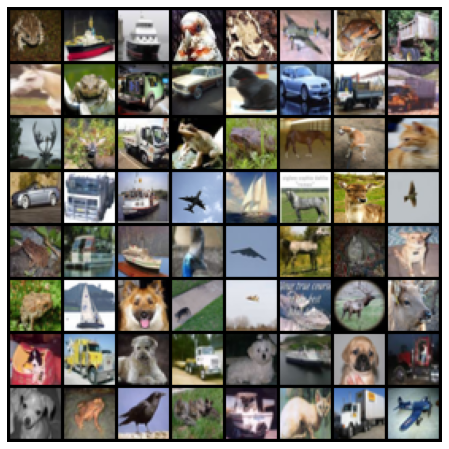

In [3]:
dataset = torchvision.datasets.CIFAR10(root='data/', download=True, transform=transforms.ToTensor())
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, num_workers=2)
print(dataset.classes)

for images, _ in loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=8).permute((1, 2, 0)))
    break
plt.show()

### Some insights extracted from the dataset exploration

The input of the Neural Network must be 3 * 32 * 32 (images shape) and the output must be equal to 10 (the number of classes).

### Split dataset into train and test set and apply normalizations

In [4]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# define the batch size for the dataloaders
batch_size = 64

train_set = torchvision.datasets.CIFAR10(root='data', train=True, download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = torchvision.datasets.CIFAR10(root='data', train=False, download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

Files already downloaded and verified
Files already downloaded and verified


### The Full Connected Neural Network Model

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self, in_layer, second_layer, third_layer, out_layer):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(in_layer, second_layer),
            nn.ReLU(),
            nn.Linear(second_layer, second_layer),
            nn.ReLU(),
            nn.Linear(second_layer, third_layer),
            nn.ReLU(),
            nn.Linear(third_layer, out_layer),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# print the model structure
# print(model)
#
# for name, param in model.named_parameters():
#     print(f"Layer: {name} | Size: {param.size()} | Values : {param[:2]} \n")


### Train and test loops in order to fit & predict data

In [6]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        # if using gpu dont forget to move the data there
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= size
    return train_loss

def test_loop(dataloader, model, loss_fn):
    """
    the test loop does not need the optimizer
    we just pass the data through the trained model and measure the error in predictions
    :param dataloader:
    :param model:
    :param loss_fn:
    :return:
    """
    size = len(dataloader.dataset)
    test_loss, correct = 0, 0

    # the no_grad command tells PyTorch that we dont want to accumulate gradients for these operations
    with torch.no_grad():
        for X, y in dataloader:
            # if using gpu dont forget to move the data there
            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size
    # print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

    return test_loss, correct

### Methods that used to plot error and loss

In [7]:
def plot_losses(history, label):
    plt.plot(history, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title(f'Loss vs. No. of epochs {label} set')
    plt.show()


def plot_accuracies(history, label):
    plt.plot(history, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title(f'Accuracy vs. No. of epochs for {label} set')
    plt.show()


### Method that apply train/test loops for a given amount of epochs, learning rate & momentum

In [8]:
def train_nn(model, num_epochs, learning_rate, momentum=0):
    # define the loss function
    loss_fn = nn.CrossEntropyLoss()

    # define the optimizer object
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

    train_loss_history = []
    test_loss_history = []
    test_accuracy_history = []

    print(f"Training for learning rate: {learning_rate}, momentum: {momentum}\n")
    for t in range(num_epochs):
        train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
        test_loss, accuracy = test_loop(test_dataloader, model, loss_fn)
        train_loss_history.append(train_loss)
        test_loss_history.append(test_loss)
        test_accuracy_history.append(accuracy)

    plot_losses(train_loss_history, 'train')
    plot_losses(test_loss_history, 'test')
    plot_accuracies(test_accuracy_history, 'test')
    print(f'Accuracy after {num_epochs} epochs: {test_accuracy_history[num_epochs-1]}')
    print(f'Loss after {num_epochs} epochs: {test_loss_history[num_epochs-1]}')

## Training and optimizing Neural Network 3 * 32 * 32, 500, 256, 10 nodes

### Train and predict for learning_rate=0.001 for 100 epochs

The learning rate of 0.001 seems to yield very optimistic results, the curve of loss on each epoch converges to 0 for both train and test.

Training for learning rate: 0.001, momentum: 0



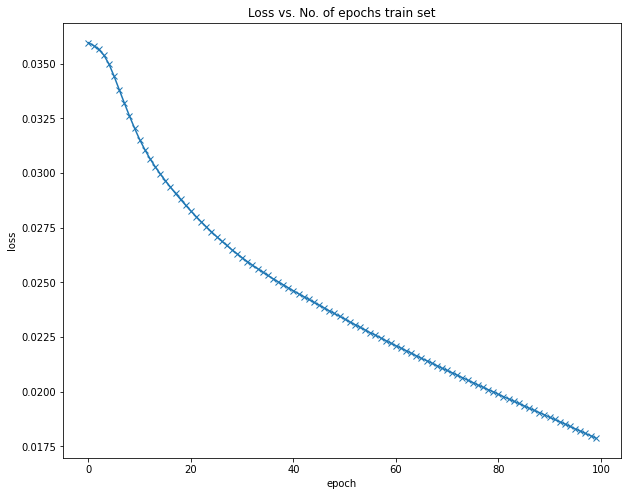

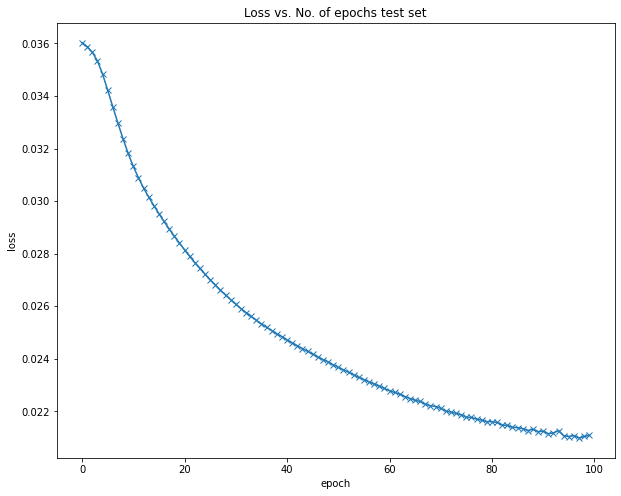

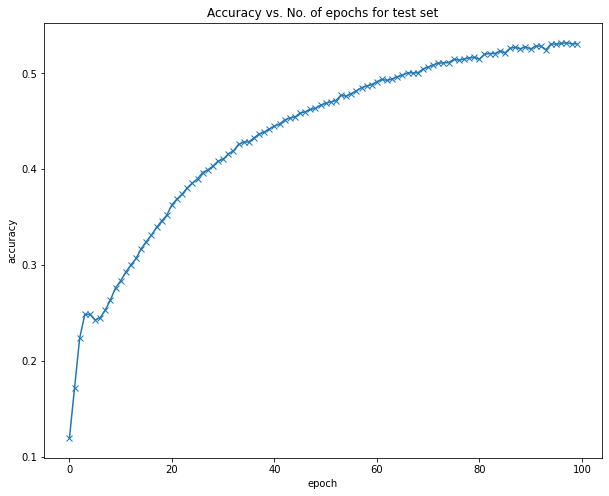

Accuracy after 100 epochs: 0.5308
Loss after 100 epochs: 0.02107869396209717


In [9]:
model = NeuralNetwork(in_layer=3 * 32 * 32, second_layer=500, third_layer=256, out_layer=10).to(device)
train_nn(model, num_epochs=100, learning_rate=0.001, momentum=0)

### Train and predict for learning_rate=0.05 for 100 epochs

The learning rate of 0.005 seems to be a bit high for 100 epochs. As you can see the loss function after epoch ~30 explodes (vanishing or exploding gradient problem).

Training for learning rate: 0.005, momentum: 0



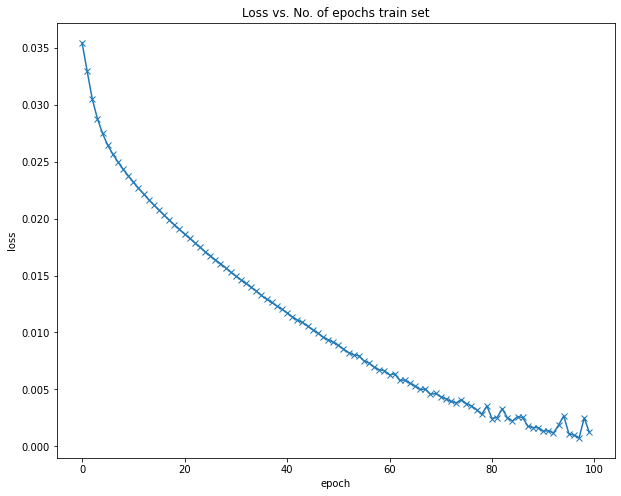

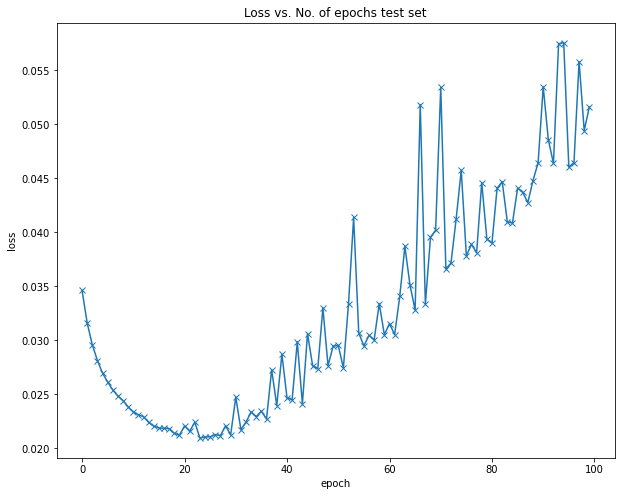

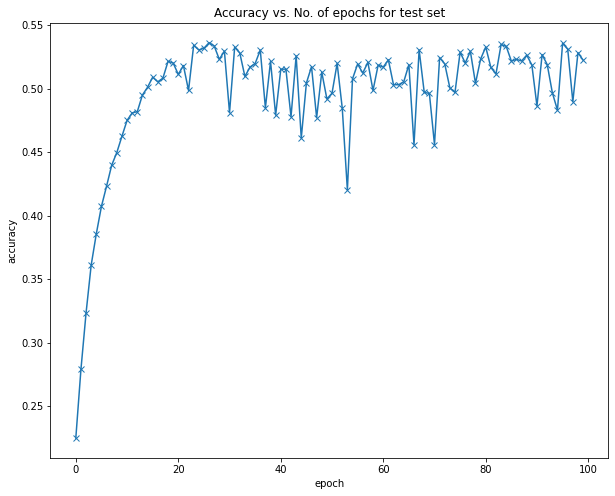

Accuracy after 100 epochs: 0.5225
Loss after 100 epochs: 0.051605379498004915


In [10]:
model = NeuralNetwork(in_layer=3 * 32 * 32, second_layer=500, third_layer=256, out_layer=10).to(device)
train_nn(model, num_epochs=100, learning_rate=0.005, momentum=0)

### Train and predict for learning_rate=0.1 for 100 epochs

The same problem (vanishing or exploding gradient problem) as it is reasonable (0.1 > 0.005) is observed here in even lower epoch. Also the model is completely overfitted here; the loss for train is close to 0 and the loss for the test is ~0.09.

Training for learning rate: 0.1, momentum: 0



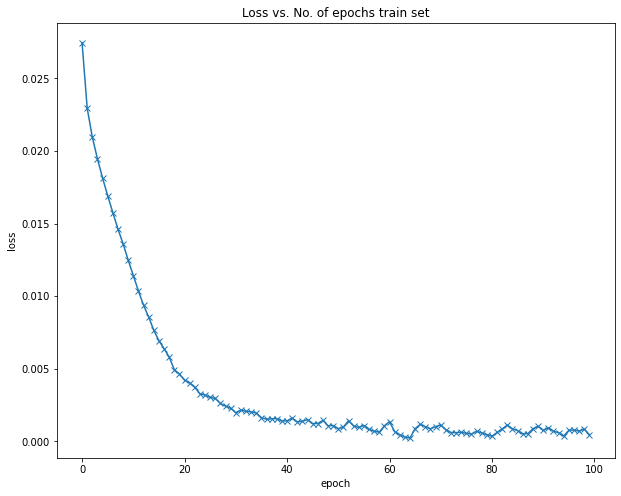

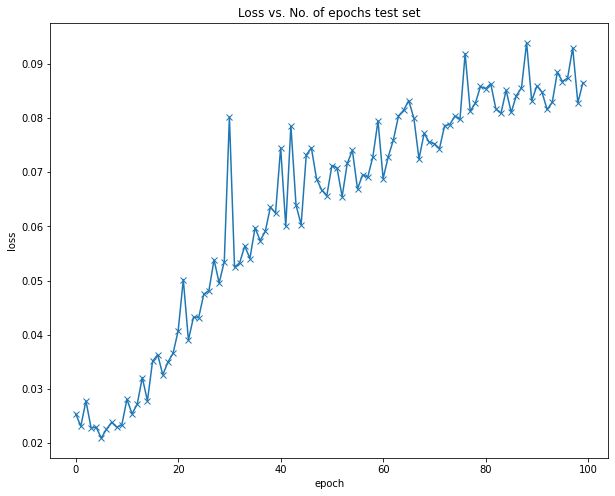

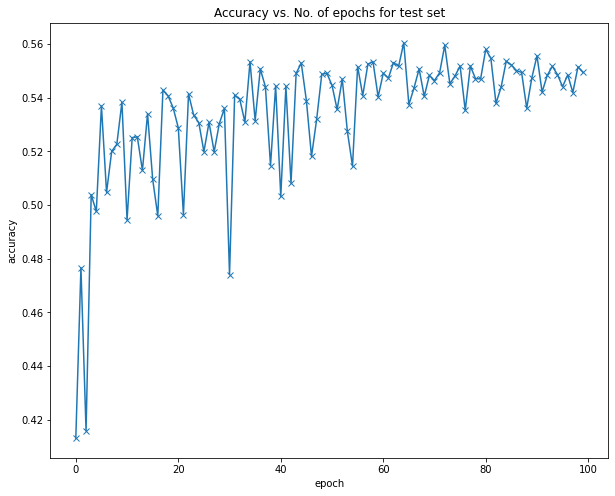

Accuracy after 100 epochs: 0.5494
Loss after 100 epochs: 0.08655853667259217


In [11]:
model = NeuralNetwork(in_layer=3 * 32 * 32, second_layer=500, third_layer=256, out_layer=10).to(device)
train_nn(model, num_epochs=100, learning_rate=0.1, momentum=0)

### Train and predict for learning_rate=0.001 & momentum=0.2 for 100 epochs

So, we can try to optimize a bit more the model with learning rate of 0.001. As you can see with momentum 0.002 we yield even better loss and accuracy. (**This model is the best of all in this notebook**)

Training for learning rate: 0.001, momentum: 0.2



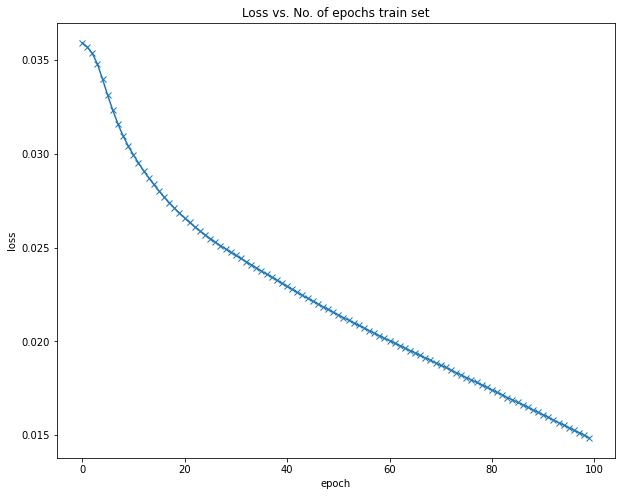

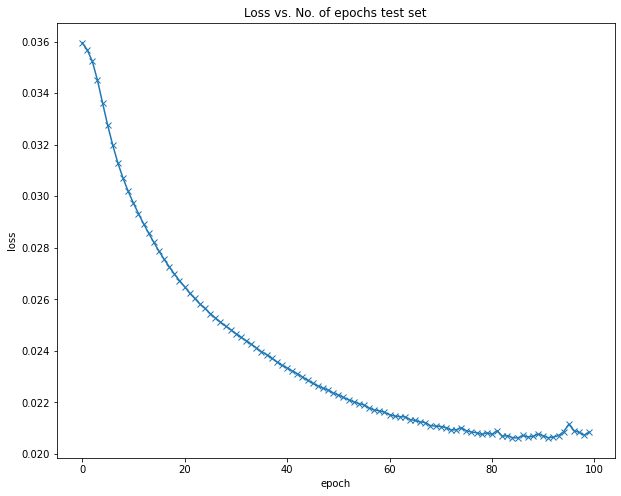

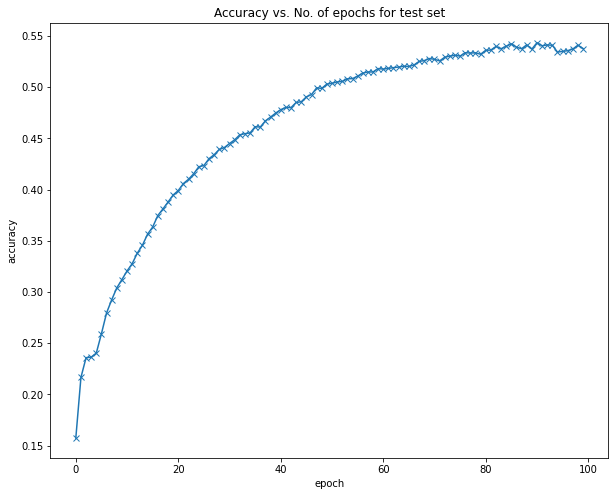

Accuracy after 100 epochs: 0.5378
Loss after 100 epochs: 0.02084922853708267


In [12]:
model = NeuralNetwork(in_layer=3 * 32 * 32, second_layer=500, third_layer=256, out_layer=10).to(device)
train_nn(model, num_epochs=100, learning_rate=0.001, momentum=0.2)

### Train and predict for learning_rate=0.001 & momentum=0.5 for 100 epochs

With momentum 0.5 the model is affected by vanishing or exploding gradient problem again.

Training for learning rate: 0.001, momentum: 0.5



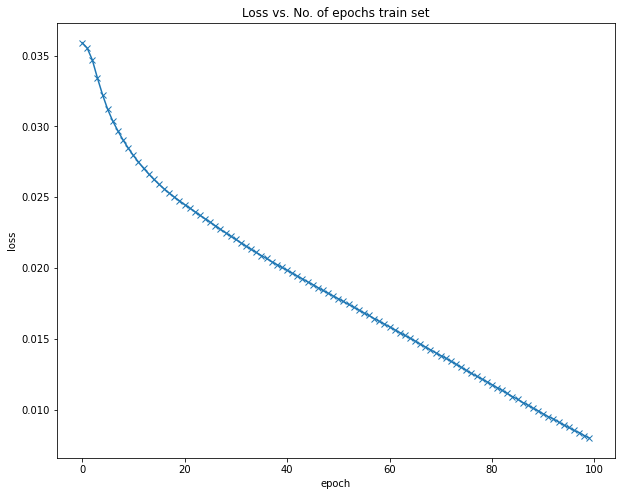

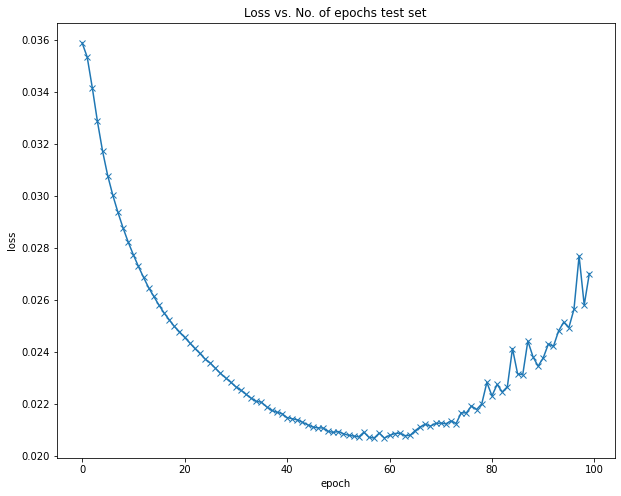

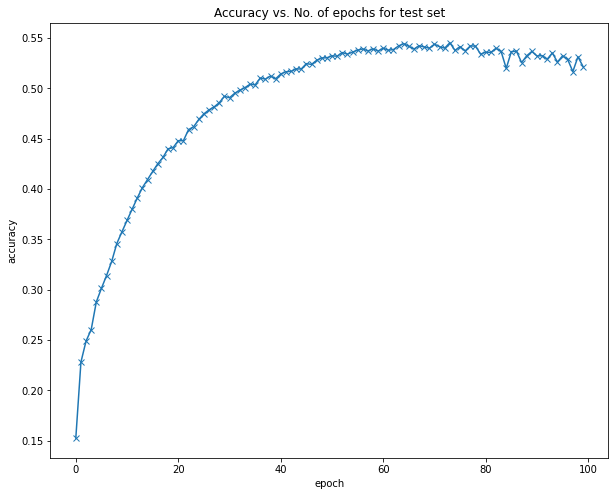

Accuracy after 100 epochs: 0.5217
Loss after 100 epochs: 0.02701496307849884


In [13]:
model = NeuralNetwork(in_layer=3 * 32 * 32, second_layer=500, third_layer=256, out_layer=10).to(device)
train_nn(model, num_epochs=100, learning_rate=0.001, momentum=0.5)

## Both models below show similar results in terms of accuracy/loss with the model of 3 * 32 * 32, 500, 256, 10 neurons, lr=0.001 & momentum 0.2.

### Training Neural Network 3 * 32 * 32, 500, 400, 10 nodes, learning_rate=0.0001, momentum=0.9

This model is pretty expensive. So many neurons and very low learning rate in order to achieve the same stats with the best previous model.

Training for learning rate: 0.0001, momentum: 0.9



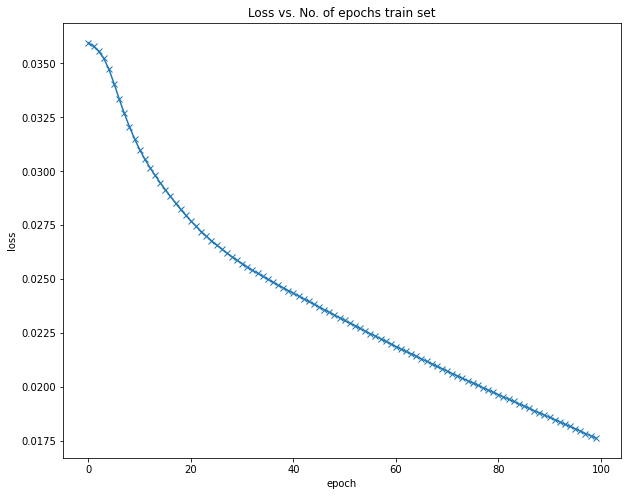

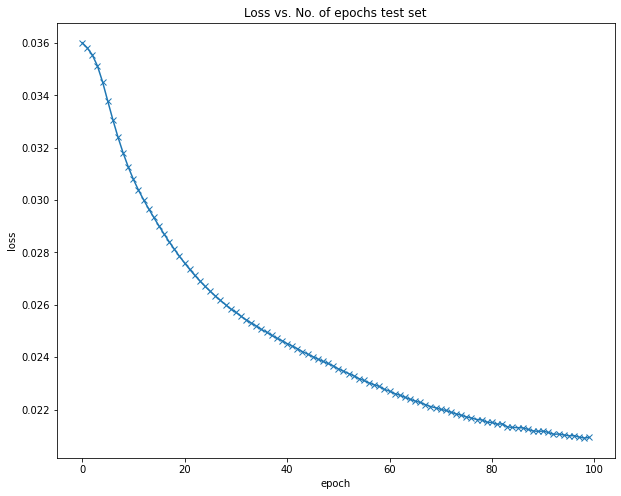

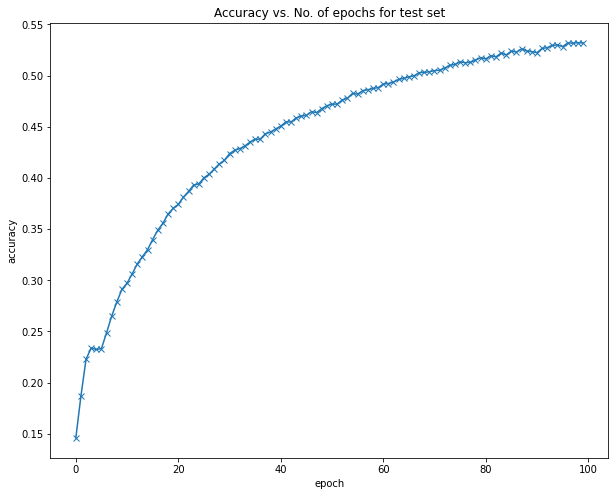

Accuracy after 100 epochs: 0.5318
Loss after 100 epochs: 0.020935856461524963


In [20]:
model = NeuralNetwork(in_layer=3 * 32 * 32, second_layer=500, third_layer=400, out_layer=10).to(device)
train_nn(model, num_epochs=100, learning_rate=0.0001, momentum=0.9)

### Training Neural Network 3 * 32 * 32, 300, 200, 10 nodes, learning_rate=0.0001, momentum=0.9

This model may be a bit more cheap in terms of neurons, but it has very low learning rate compared to the best model above. Also, it has slightly worse accuracy and loss.

Training for learning rate: 0.0001, momentum: 0.9



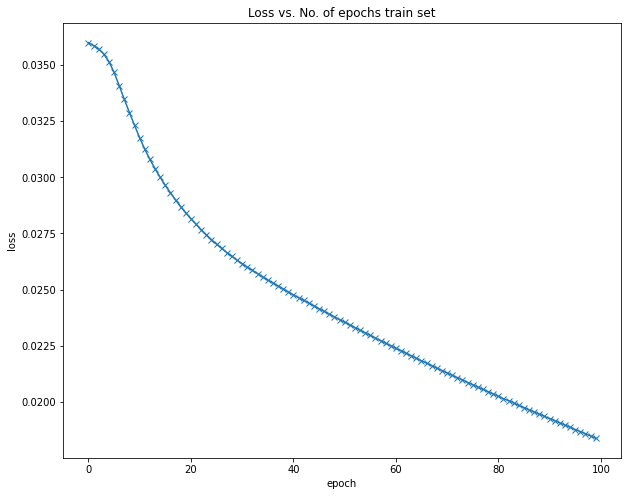

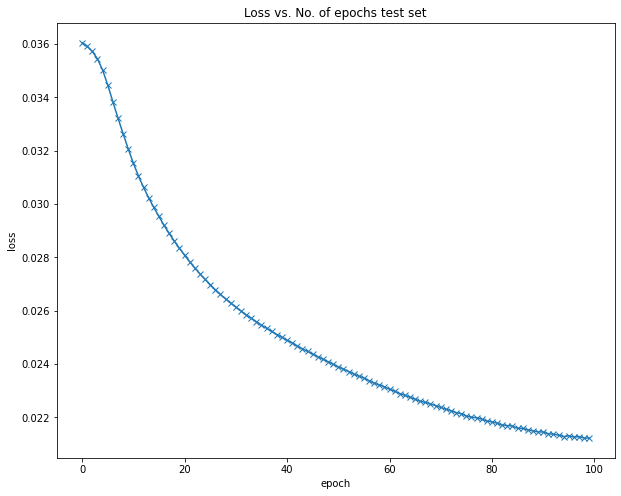

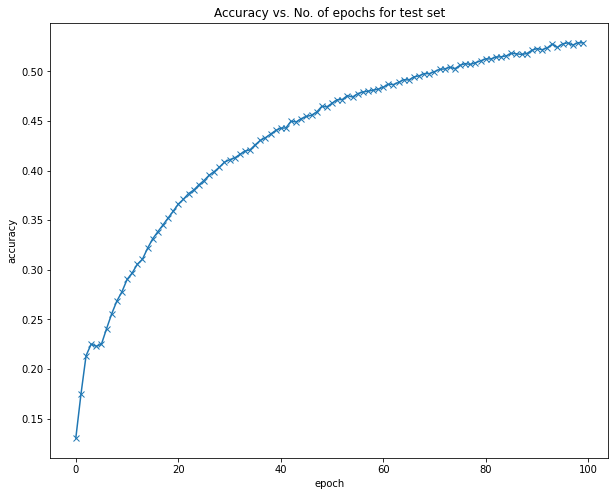

Accuracy after 100 epochs: 0.5287
Loss after 100 epochs: 0.02122510141134262


In [21]:
model = NeuralNetwork(in_layer=3 * 32 * 32, second_layer=300, third_layer=200, out_layer=10).to(device)
train_nn(model, num_epochs=100, learning_rate=0.0001, momentum=0.9)